In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()

# Loading Reference name to Taxa Id file

In [2]:
ref = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/seqid2taxid.map"
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

# Loading Taxonomy Tree
### Taxum ID , Taxum Rank , Taxum Parent ID

In [3]:
tf = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/taxonomy/nodes.dmp"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]

In [4]:
taxa_df.head()

,taxaId,pid,rank
0,1,1,no rank
1,2,131567,superkingdom
2,6,335928,genus
3,7,6,species
4,9,32199,species


# Truth

In [20]:
def calc_precRecall(truth_pred):
    alltruth = truth_pred['trueCount'].sum()
    tp = truth_pred[['predCount', 'trueCount']].min(axis=1).sum()
    recall = tp/alltruth
    prediction = truth_pred['predCount'].sum()
    prec = tp/prediction
    f1 = 2*(prec*recall)/(prec+recall)
    return [prec, recall, f1]

In [74]:
# assumption:
# 0: id, 1: rank, 2: count, 3: aggregatedCount
def truth_aggregate(taxa_df, df, keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        nodeId = row.iloc[0]
        count = row.iloc[2]
        res[(nodeId, row.iloc[1])] = count # id, rank --> aggregated count
        while (nodeId != 1):
            parId = taxa_df[taxa_df['taxaId'] == nodeId].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            res[(parId, pnode['rank'].values[0])] += count
            nodeId = parId
    res_list = []
    for k, v in res.items():
        #print([k[0], k[1], v])
        res_list.append([k[0], k[1], v])
    return pd.DataFrame(res_list, columns=['trueId', 'trueRank', 'trueCount'])

In [73]:
# assumption:
# 0: id, 1: rank, 2: count
def aggregate(taxa_df, df, level = 'species', keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        node = [row.iloc[0], row.iloc[1], row.iloc[2]]
        while (node[1] != level and node[0] != 1):
            parId = taxa_df[taxa_df['taxaId'] == node[0]].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            node = [pnode.taxaId.values[0], pnode['rank'].values[0], node[2]]
        if node[1] == level:
            res[node[0]] += node[2]
    return pd.DataFrame(list(res.items()), columns=['trueId', 'trueCount'])

In [5]:
truthfile = '/mnt/scratch2/avi/meta-map/kraken/meta/truth.txt'
truth = pd.read_csv(truthfile, sep="\t")

In [6]:
truth.head()

,taxid,counts,species,size,dataset
0,79329,24666,Chitinophaga pinensis,9127347,Huttenhower_HC1
1,1836,22195,Saccharopolyspora erythraea,8079083,Huttenhower_HC1
2,152480,20654,Burkholderia ambifaria,8095900,Huttenhower_HC1
3,182640,20483,Kribbella flavida,7579488,Huttenhower_HC1
4,80866,18289,Delftia acidovorans,6823175,Huttenhower_HC1


In [75]:
ds_truth = {}
for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
    
    dataset_truth = truth[truth['dataset'] == 'Huttenhower_{}'.format(dataset)]
    dataset_truth = pd.merge(dataset_truth, taxa_df, left_on='taxid', right_on='taxaId')
    dataset_truth = dataset_truth[['taxaId', 'rank', 'counts']]
    dataset_truth.columns = [['trueId', 'rank', 'trueCount']]
    ds_truth[dataset] = truth_aggregate(taxa_df, dataset_truth)
    for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
        key = dataset + '-' + level
        ds_truth[key] = aggregate(taxa_df, dataset_truth, level)

In [81]:
def prepare(krakenf, pufferf):
    stats = []
    ds_puffer = {}
    ds_kraken = {}
    for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
        print(dataset)
        #krakenf = '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format(dataset)
        krakenf_formatted = krakenf.format(dataset)
        kraken = pd.read_csv(krakenf_formatted, sep="\t", header=None)
        kraken.columns = ['totalPerc', 'totalCount', 'count', 'r', 'id', 'rankScientificName']
        kraken = kraken[['id', 'totalCount']]
        kraken = pd.merge(kraken, taxa_df, left_on='id', right_on='taxaId')
        kraken = kraken[['id','rank', 'totalCount']]
        kraken.columns = ['predId', 'predRank', 'predCount']

        #pufferf = '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out'.format(dataset)
        pufferf_formatted = pufferf.format(dataset)
        puffer = pd.read_csv(pufferf_formatted, sep="\t")
        puffer = puffer[puffer['taxaId'] > 0]
        puffer.columns = ['predId', 'predRank', 'predDirectCount', 'predCount']
        
        ds_truth_puffer_joined = pd.merge(ds_truth[dataset], puffer, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
        puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)

        ds_truth_kraken_joined = pd.merge(ds_truth[dataset], kraken, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
        kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)

        stats += [(dataset, 'all',
                    puff_pears, puff_spear, puff_mard, puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2])]
        for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
            #print(level)
            key = dataset + '-' + level
            #hc1_truth[key] = aggregate(taxa_df, dataset_truth, level)
            ds_puffer[key] = puffer[puffer['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, puffer, level)
            ds_kraken[key] = kraken[kraken['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, kraken, level)
            #ds_truth[key].columns = ['trueId', 'trueCount']
            #ds_puffer[key].columns = ['predId', 'predCount']
            #ds_kraken[key].columns = ['predId', 'predCount']
            ds_truth_puffer_joined = pd.merge(ds_truth[key], ds_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
            puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)

            ds_truth_kraken_joined = pd.merge(ds_truth[key], ds_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
            kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)

            stats += [(dataset, level,
                    puff_pears, puff_spear, puff_mard, puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2])]
    stats_df = pd.DataFrame.from_records(stats, columns = ['dataset', 'level', 
                                   'puff_pearson', 'puff_spearman', 'puff_mard', 'puff_prec', 'puff_rec', 'puff_f1',
                                     'kraken_pearson', 'kraken_spearman', 'kraken_mard', 'kraken_prec', 'kraken_rec', 'kraken_f1']) 
    stats_df['krakpuff_mard_diff'] = stats_df['kraken_mard']-stats_df['puff_mard']
    stats_df['puffkrak_spearman_diff'] = stats_df['puff_spearman']-stats_df['kraken_spearman']
    stats_df['puffkrak_pearson_diff'] = stats_df['puff_pearson']-stats_df['kraken_pearson']
    stats_df['puffkrak_f1_diff'] = stats_df['puff_f1']-stats_df['kraken_f1']
    return (stats_df, ds_kraken, ds_puffer)

In [85]:
def draw_plots(stats_df):

    datasets = ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']
    levels = ['all', 'species', 'genus', 'family', 'order', 'class', 'phylum']
    statistics = ['spearman', 'pearson', 'mard', 'f1']


    for st in statistics:
        print('\n\n{}'.format(st))
        plt.subplots(3, 3, figsize=[30, 10])
        index = np.arange(len(datasets))
        bar_width = 0.35
        opacity = 0.8

        i = 1
        for level in levels:
            plt.subplot(3, 3, i)
            plt.bar(index, stats_df[stats_df['level'] == level]['puff_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='b',
                             label='Puffer')

            plt.bar(index + bar_width, stats_df[stats_df['level'] == level]['kraken_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='g',
                             label='Kraken')

            #plt.xlabel('Datasets', fontsize=14)
            plt.ylabel(st, fontsize=20)
            #plt.title('Scores by person')
            plt.xticks(index + bar_width, stats_df[stats_df['level'] == level]['dataset'])
            plt.legend()
            plt.title(level, fontsize=22)
            i += 1
        plt.tight_layout()
        plt.show()

# No Filtering



spearman


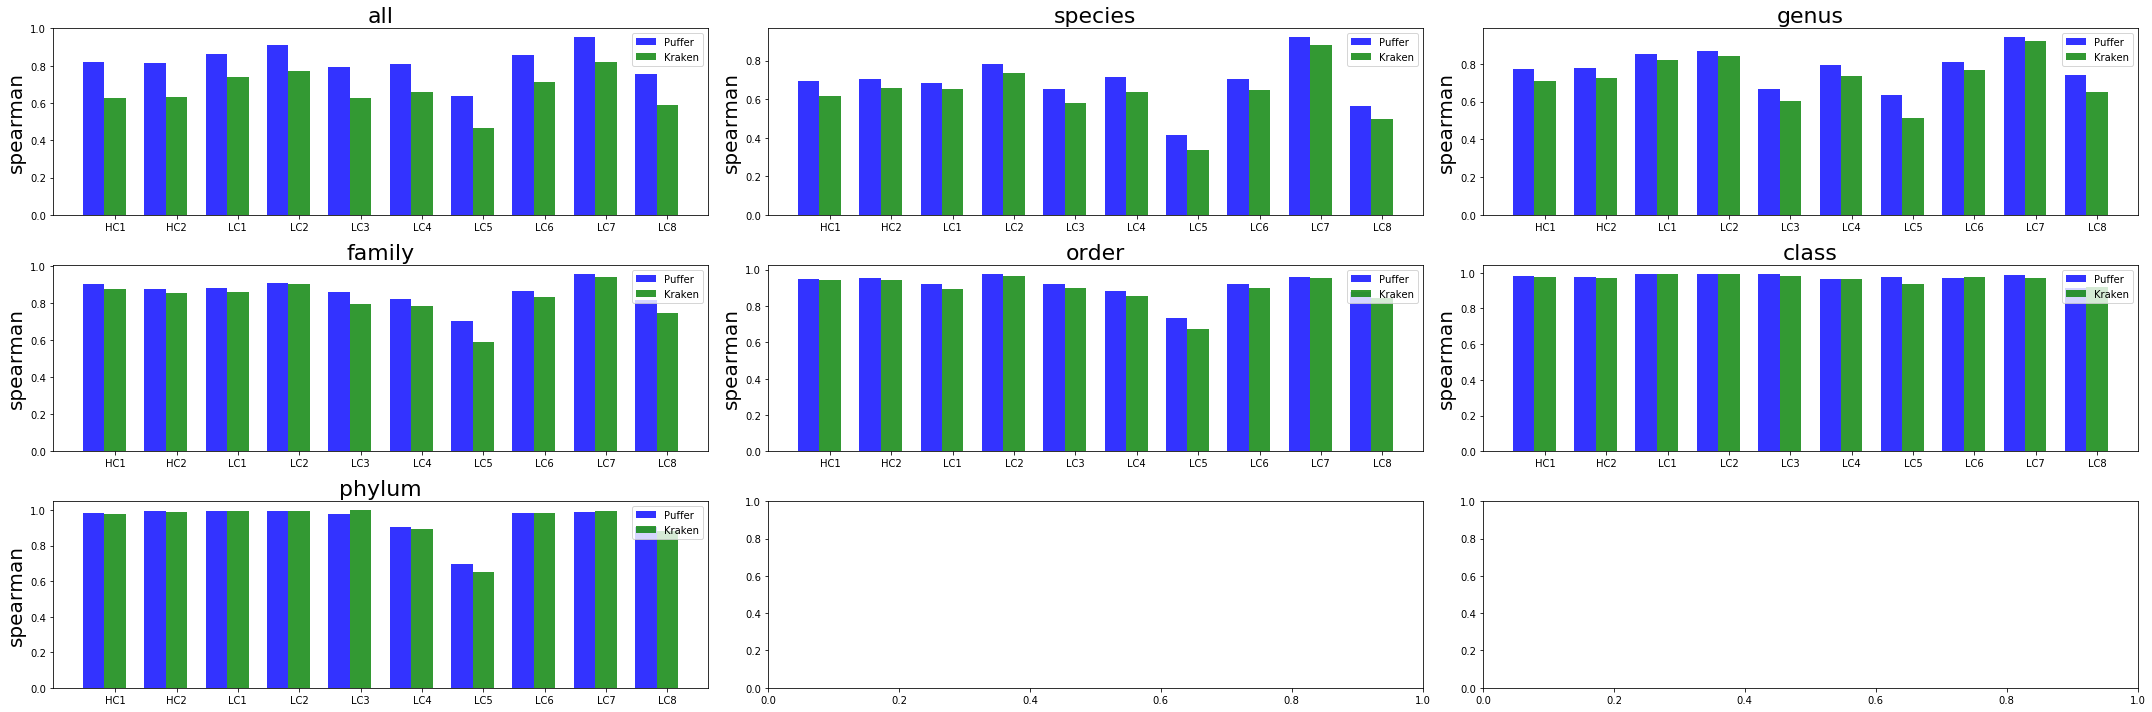



pearson


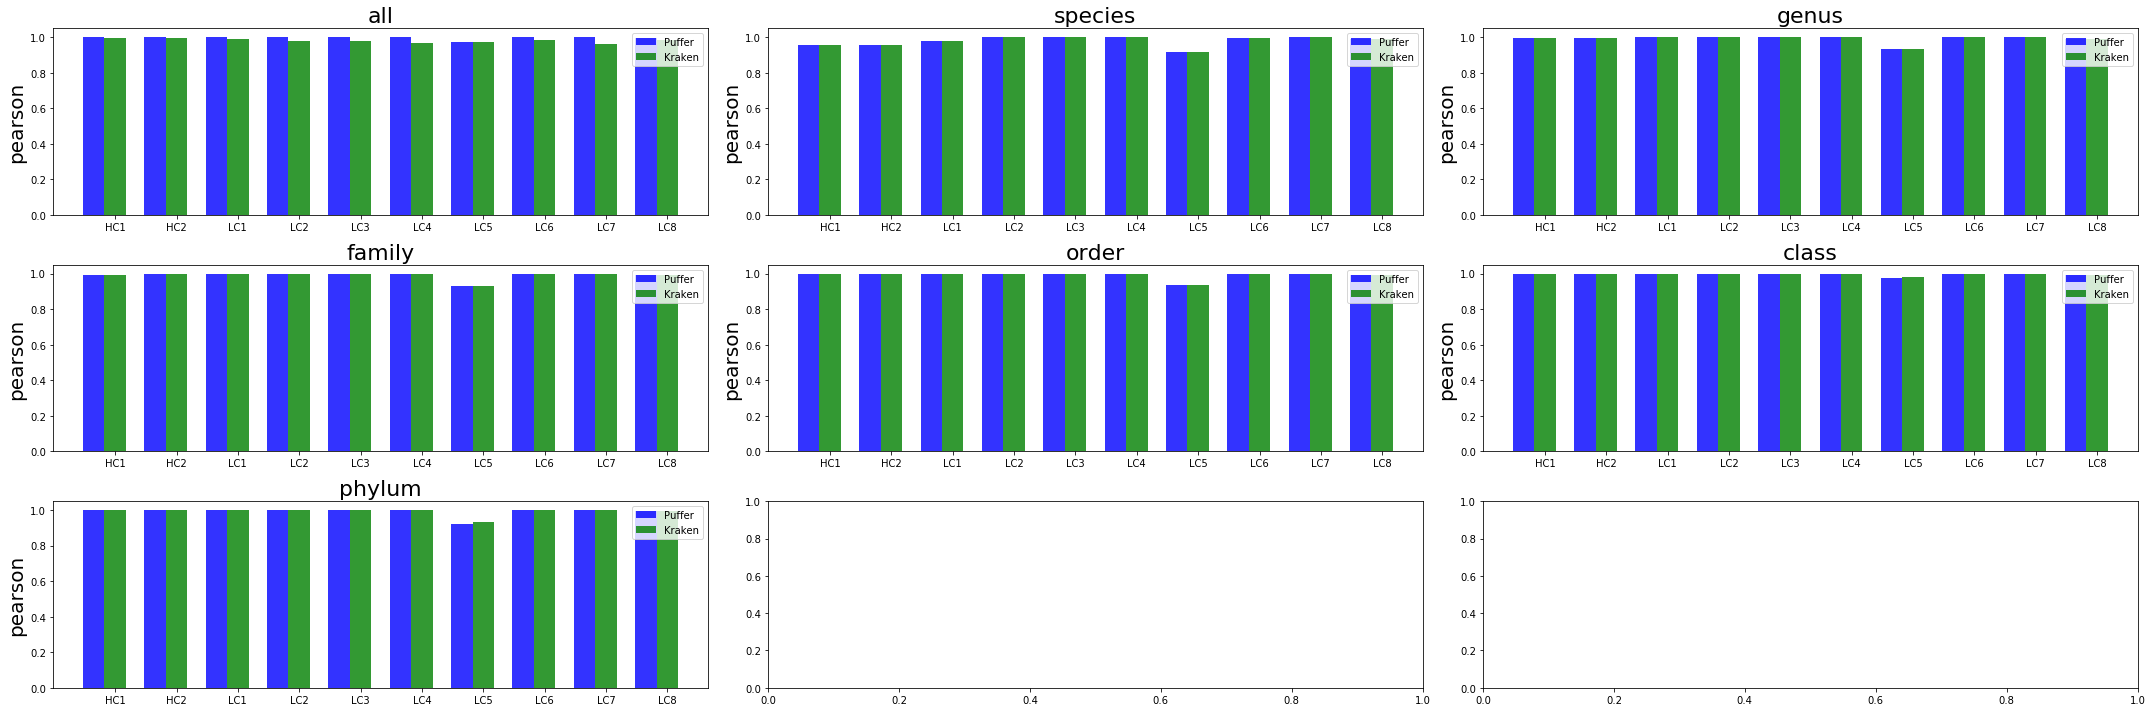



mard


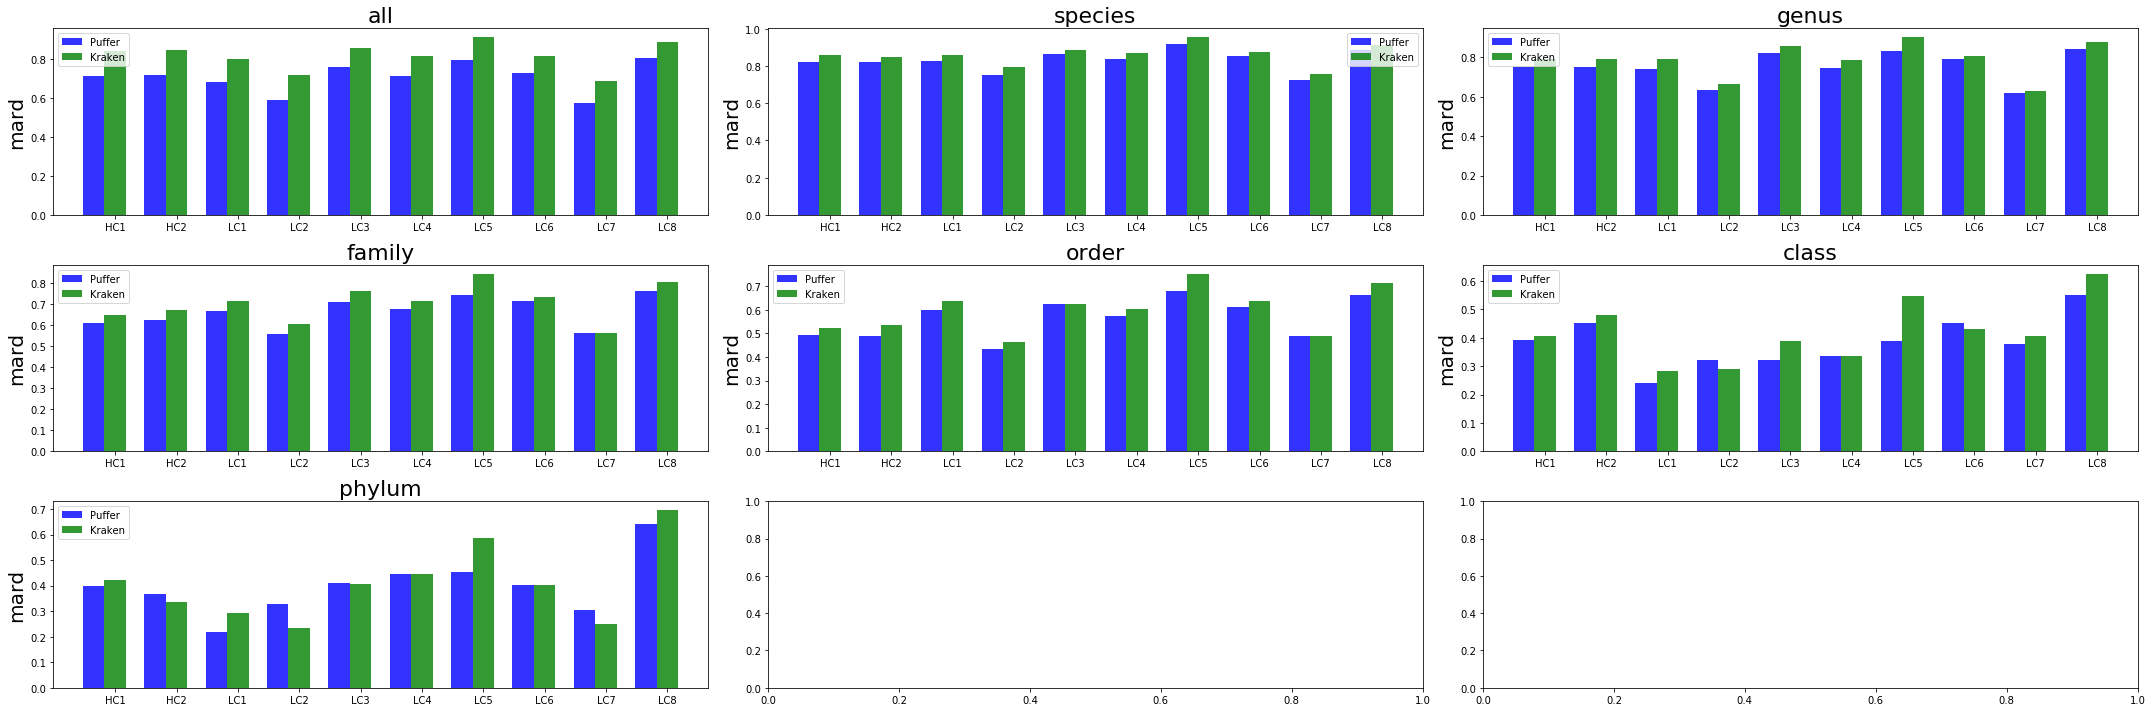



f1


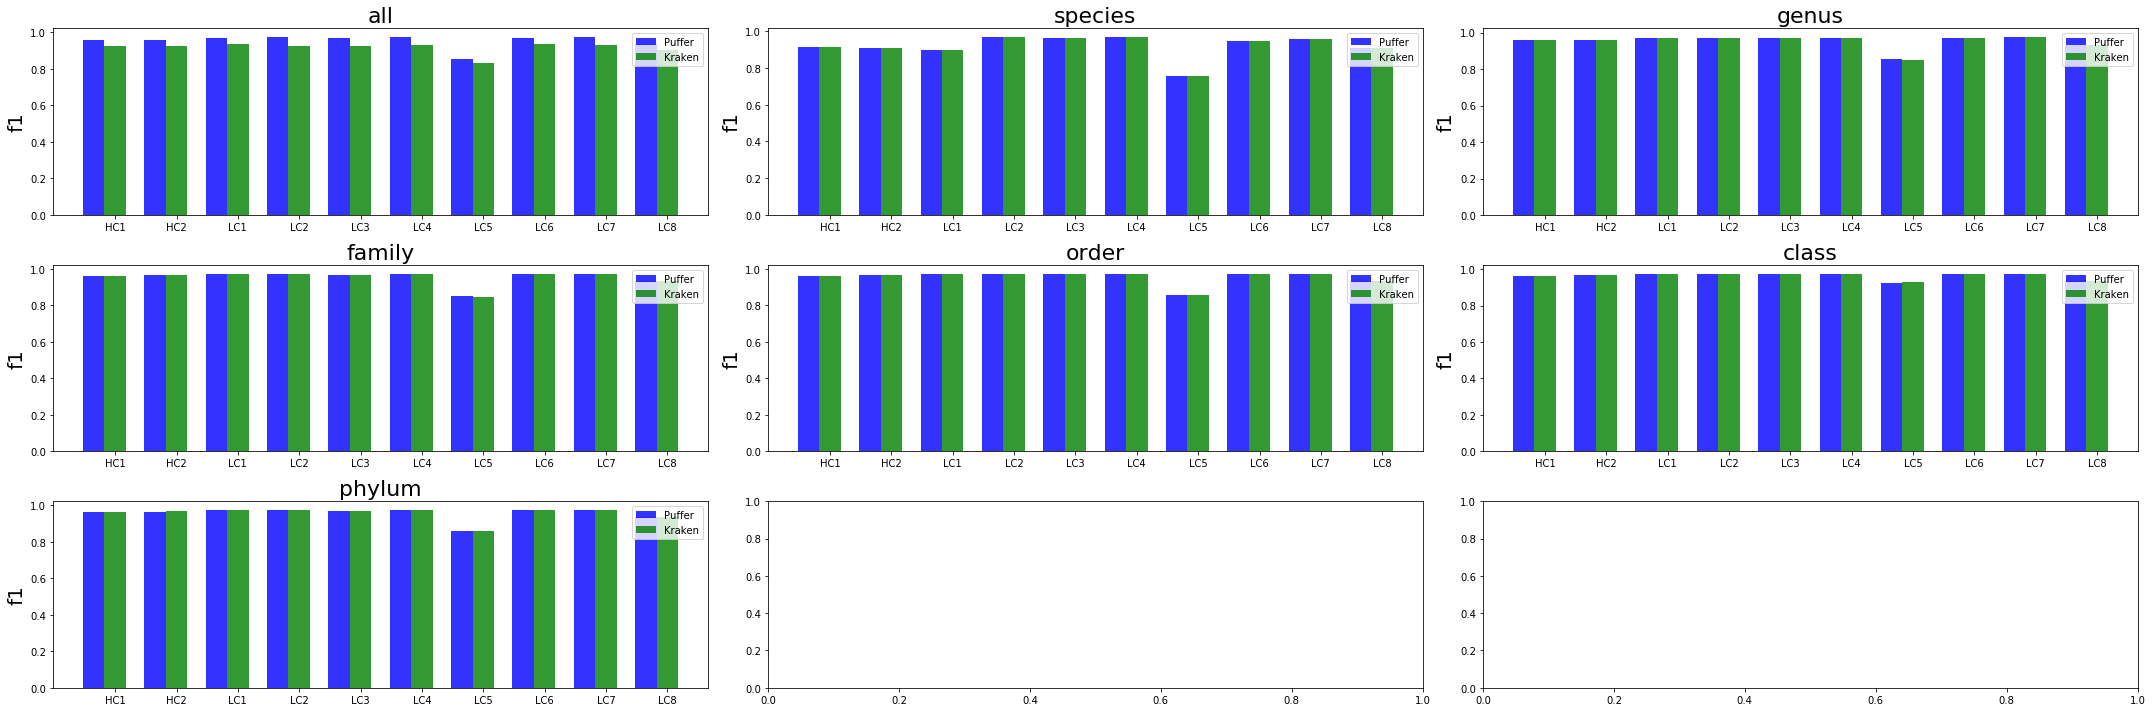

In [86]:
(stats_df, kraken, puffer) = prepare('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}_unfilt.rpt', 
                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species_unfilt.out')
draw_plots(stats_df)

# Filter coverage less than 20 percent normalized by read len

HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


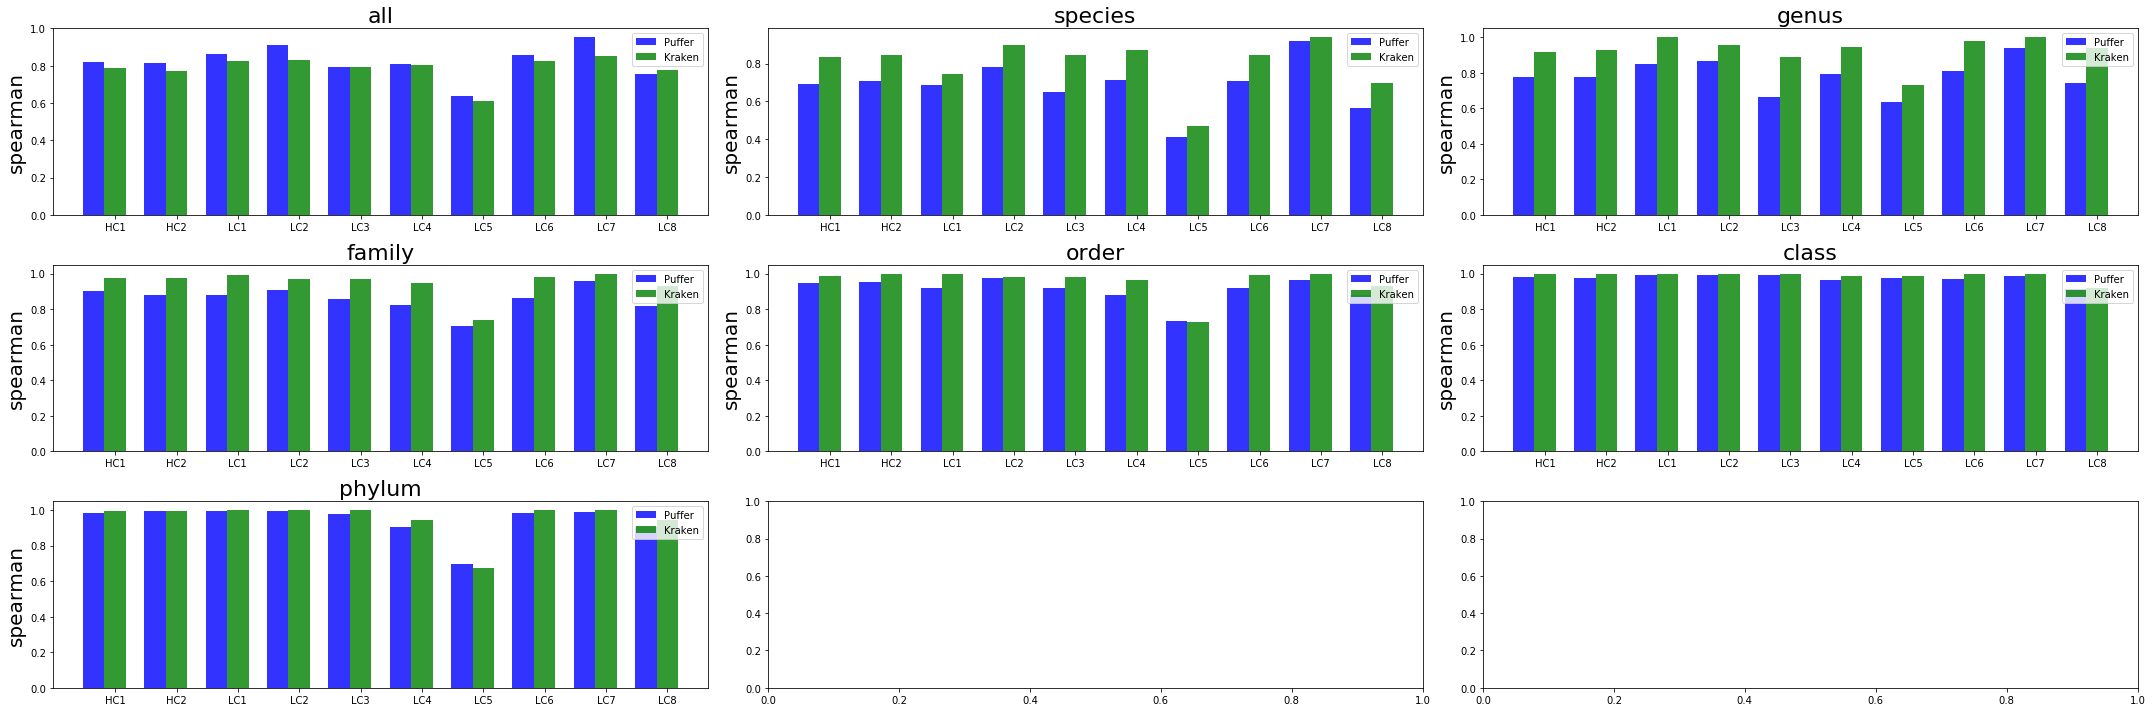



pearson


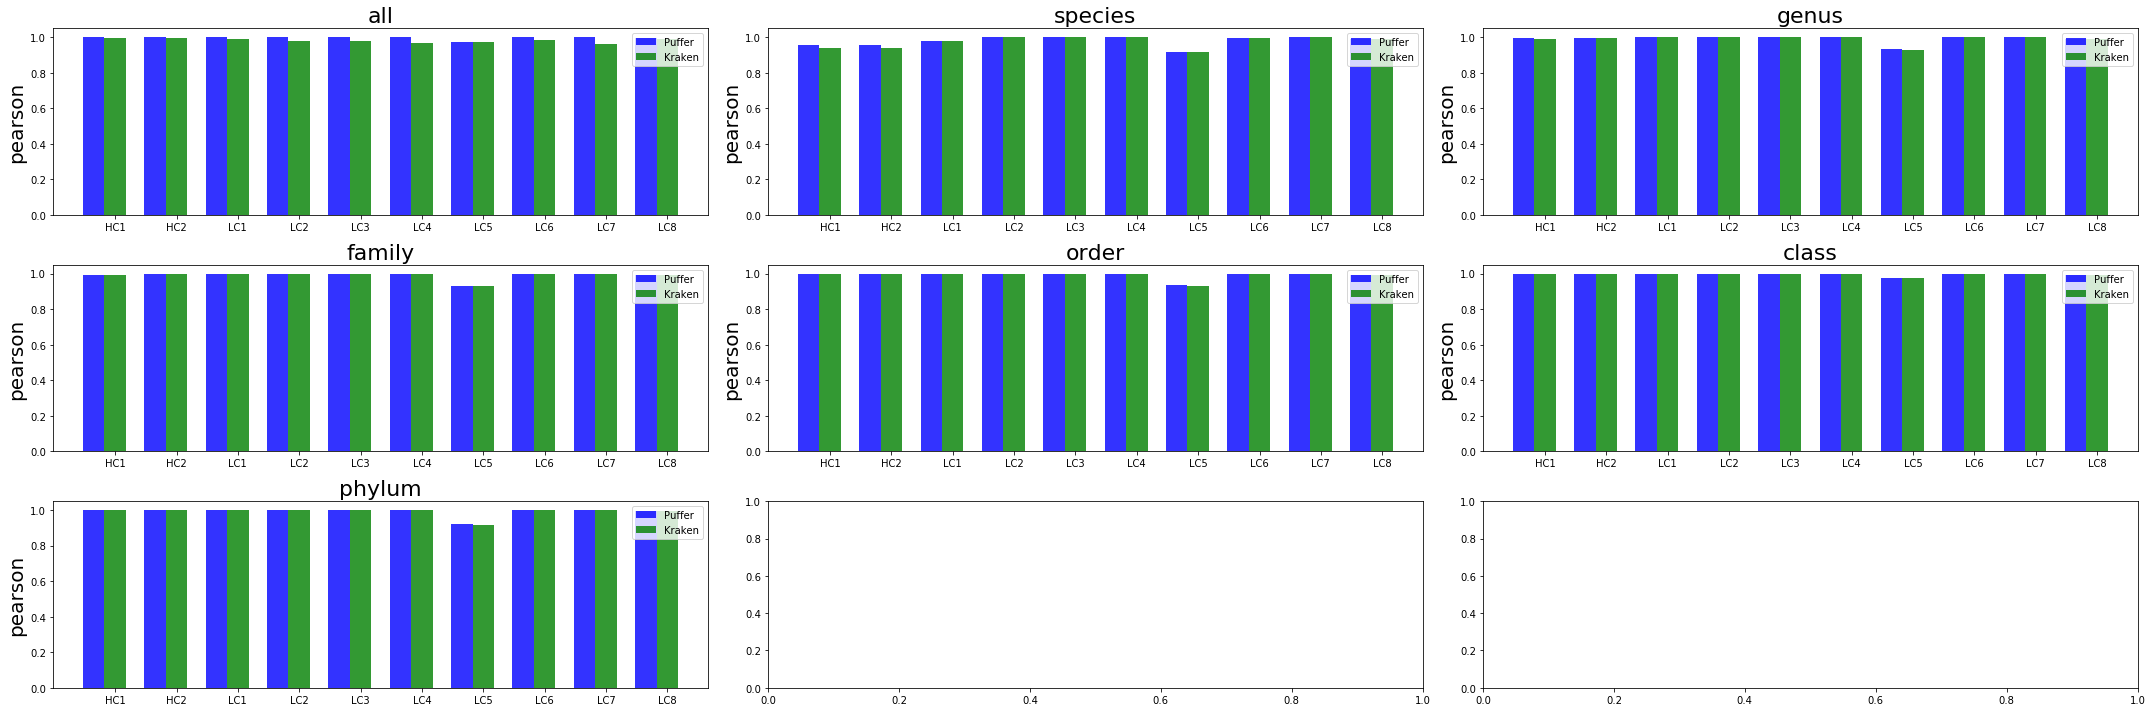



mard


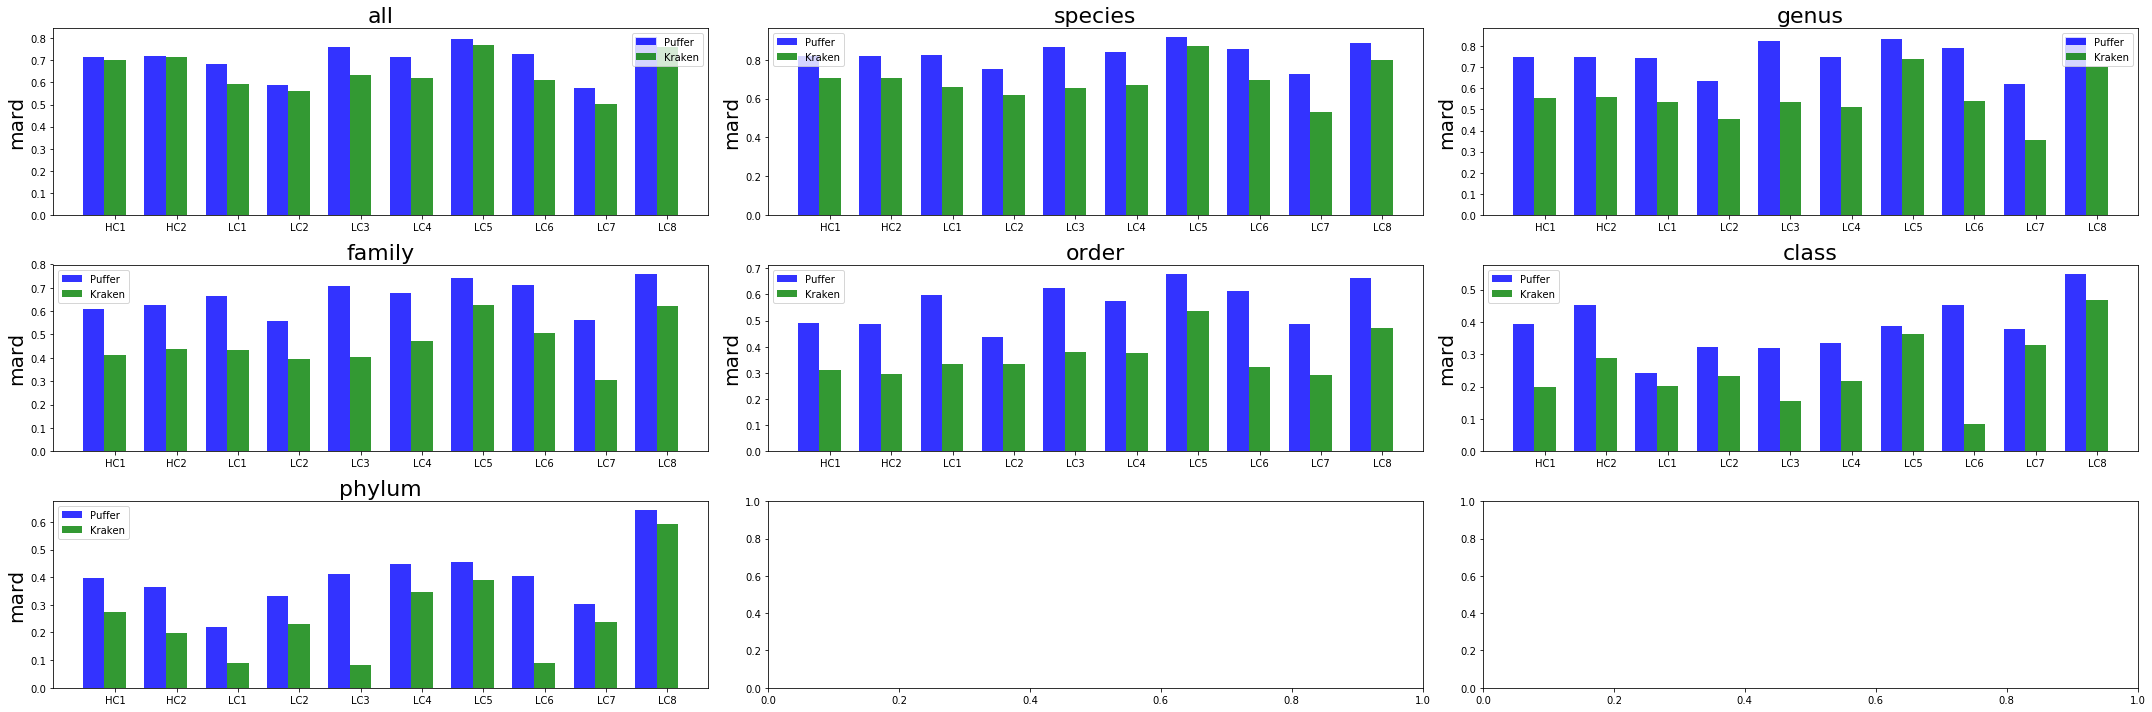



f1


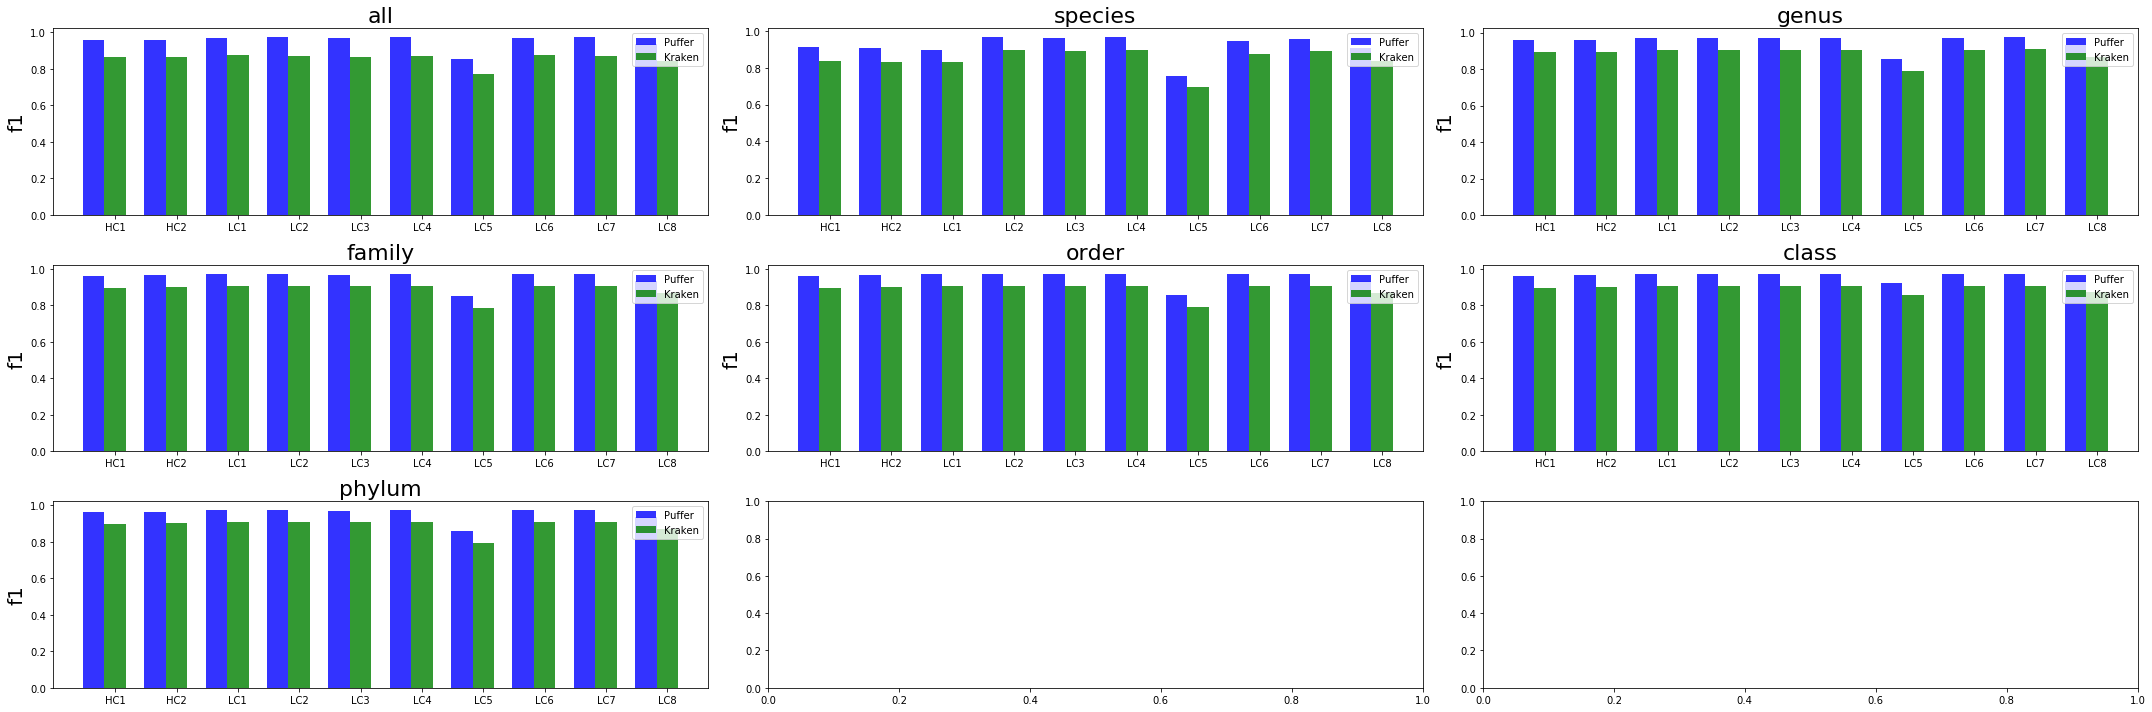

In [87]:
(stats20_df, kraken20, puffer20) = prepare('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out')
draw_plots(stats20_df)

# Filter coverage less than 44 nucleotides

HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


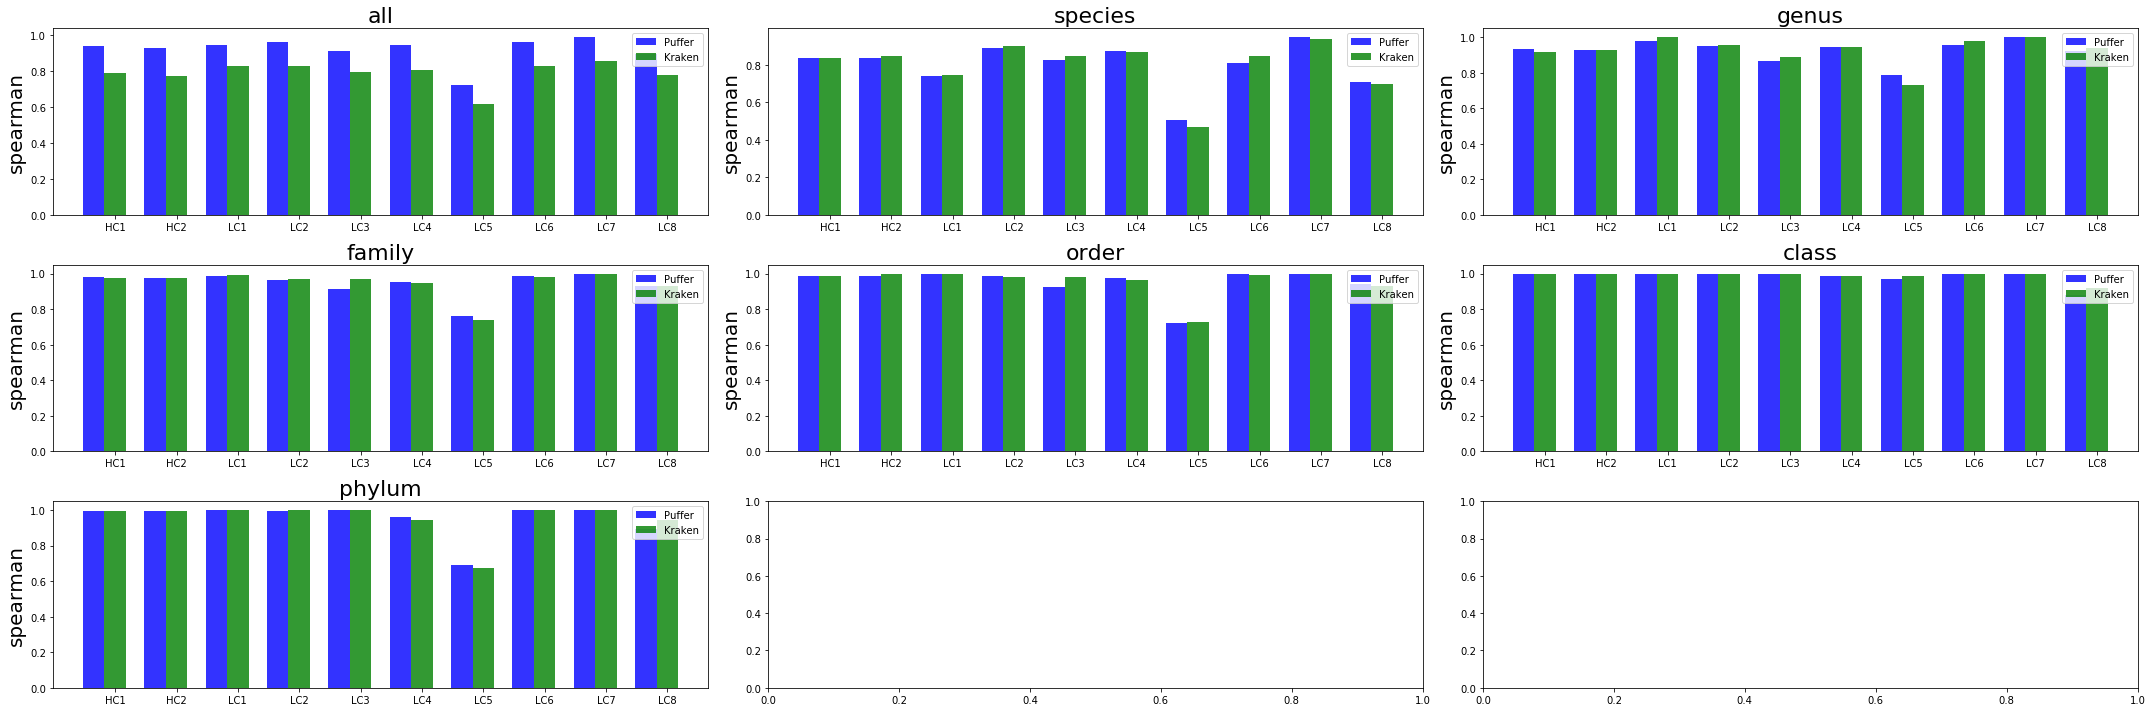



pearson


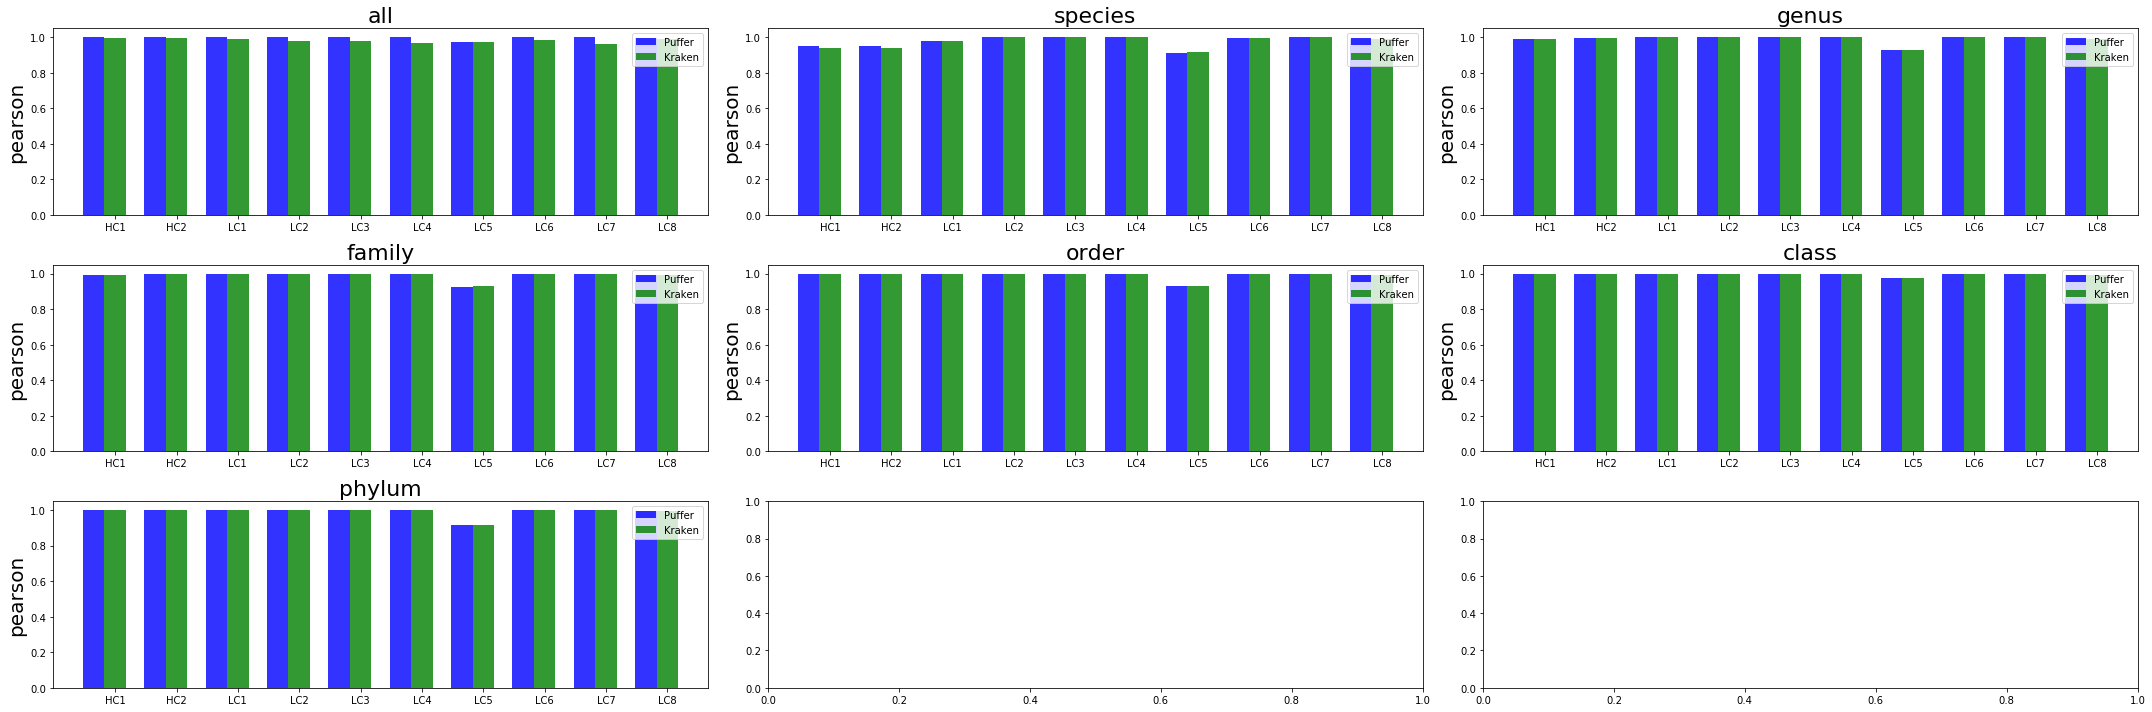



mard


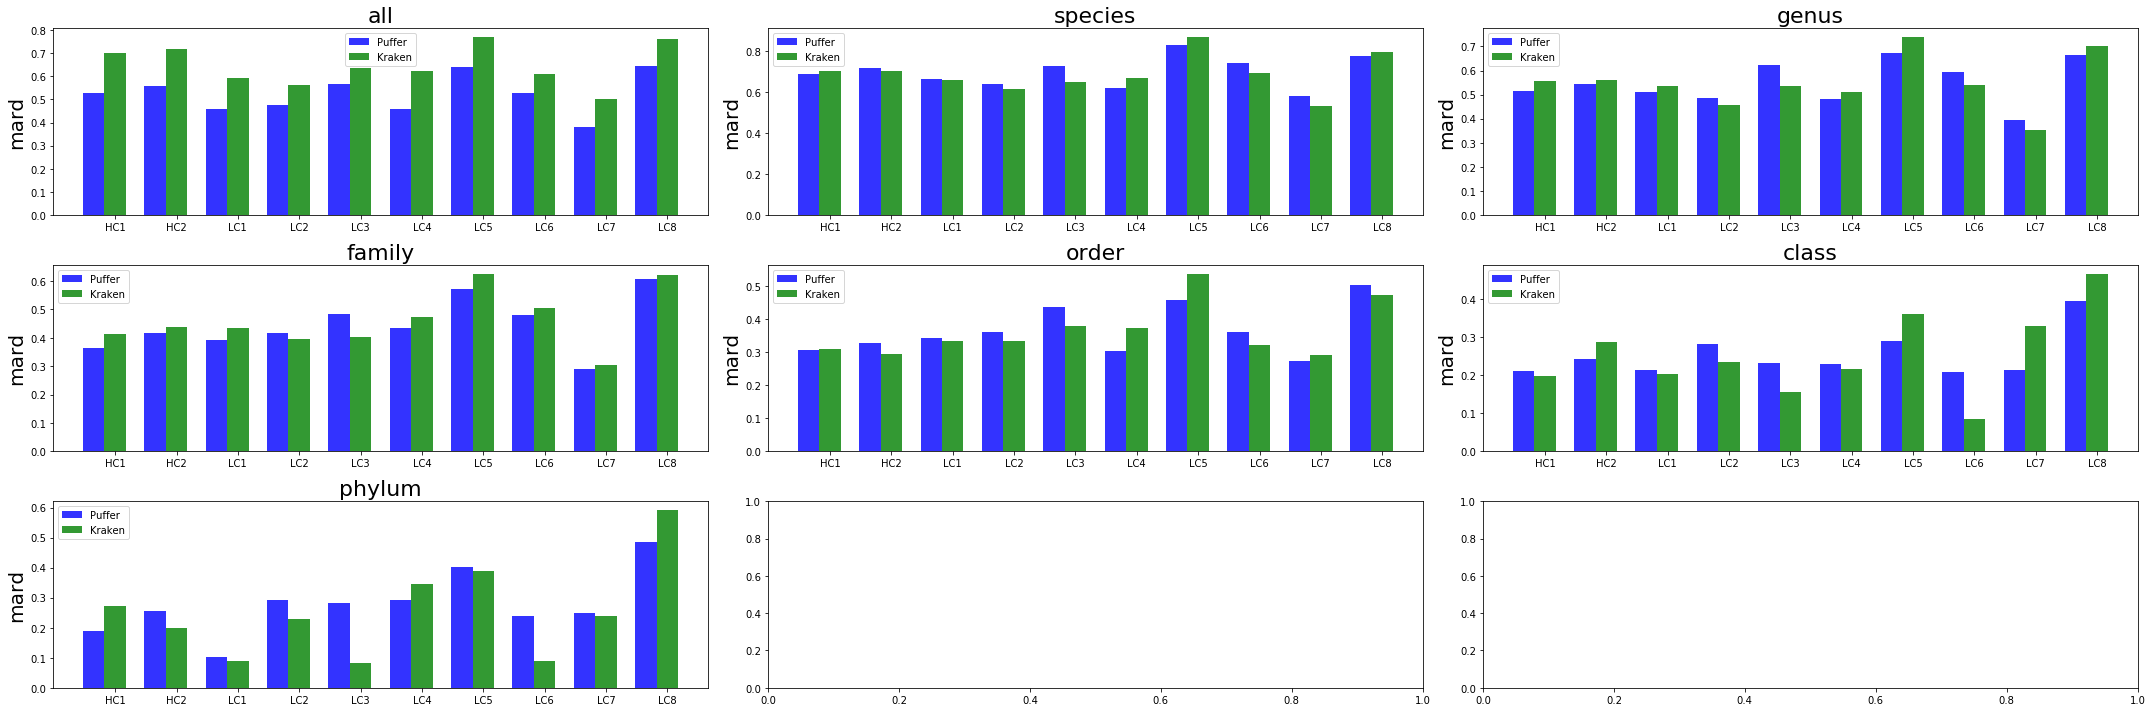



f1


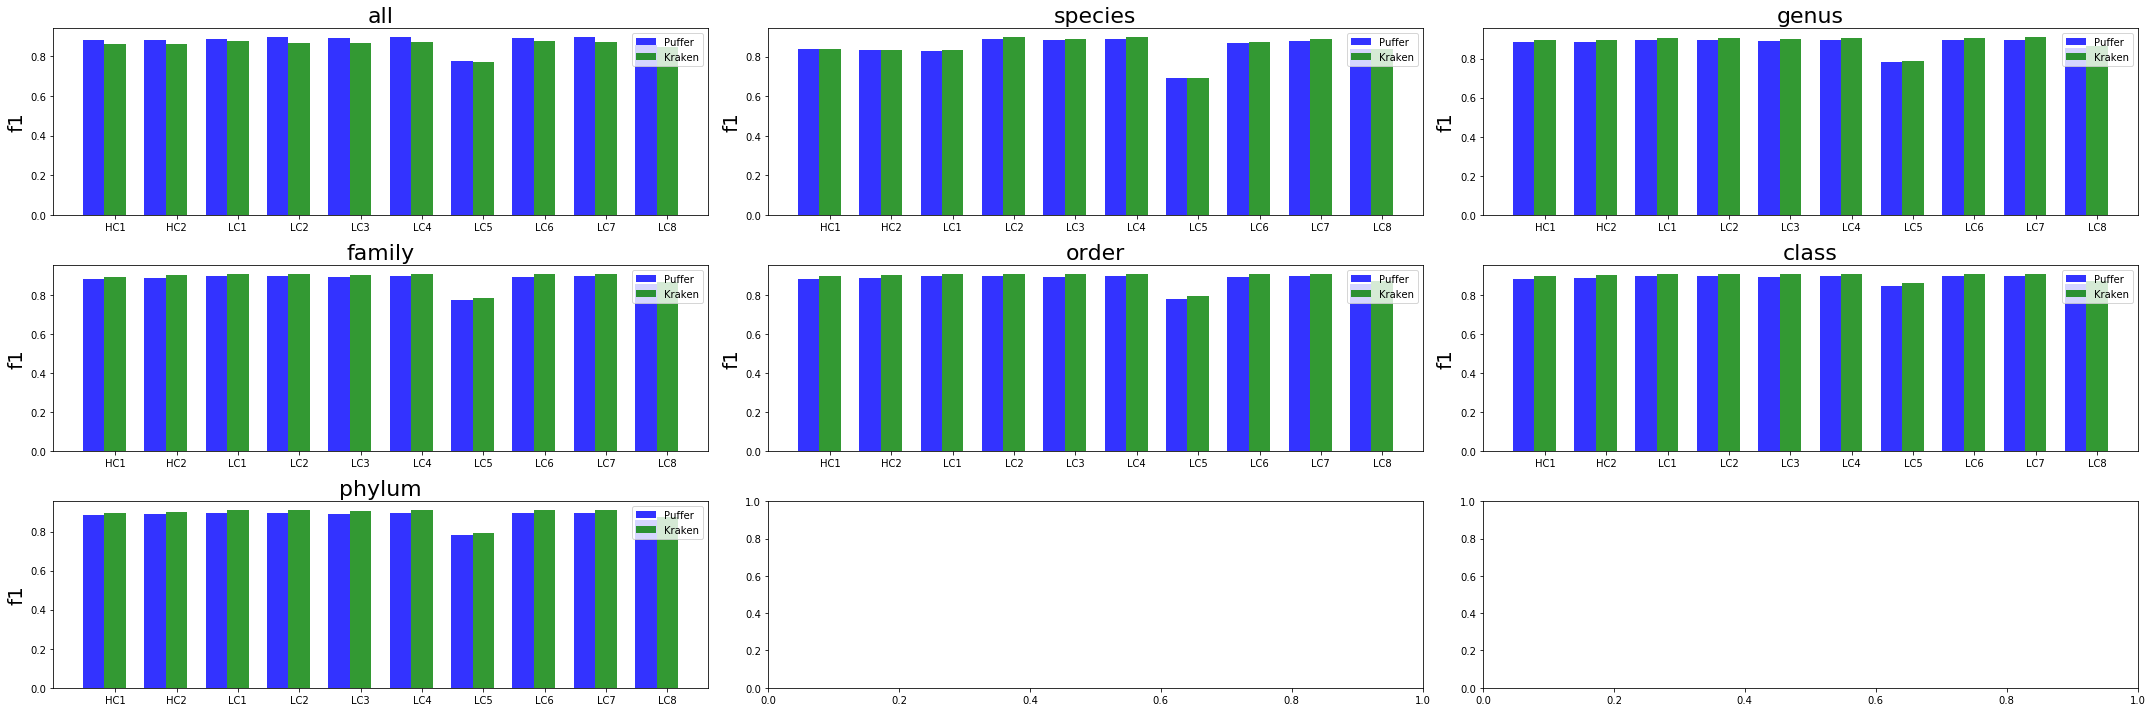

In [88]:
(stats44_df, kraken20, puffer44) = prepare('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                           '/mnt/scratch2/fatemeh/krakpuff/{}_species44.out')
draw_plots(stats44_df)
#stats44_df